# Example for $R_\text{eff}$
Model using JHU data for Germany.

Runtime ~ 15 min

The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.

In [28]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import datetime
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import aesara
import aesara.tensor as at
import pymc as pm
import pickle
import importlib
import pandas as pd

# Now to the fun stuff, we import our module!
%autoreload
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../")
    import covid19_inference as cov19

In [70]:
country = "Germany"

## Data retrieval

The next thing we want to do is (down)load a dataset. 

In [30]:
jhu = (
    cov19.data_retrieval.JHU()
)  # One could also parse True to the constructor of the class to force an auto download
jhu.download_all_available_data()

"""
    We can now access this downloaded data by the attribute
    ```
    jhu.data
    ```
    but normally one would use the build in filter methods,
    these can be found [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html#covid19_inference.data_retrieval.JHU.get_new).

    Next we retrieve the filtered data from our source in this example we will get all new cases and the total (cumulative) cases for the bundesland "Sachsen".
"""

bd = datetime.datetime(2020, 3, 1)  # For the date filter
ed = datetime.datetime(2020, 5, 31)

new_cases_obs = jhu.get_new(
    value="confirmed", country=country, data_begin=bd, data_end=ed
)

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


## Create the model

First we need to set the priors for the change points and other configs.

In [31]:
def return_change_point_dates(start_date_in, end_date_in, delta_days_in):
    dates = []
    date = start_date_in
    while date <= end_date_in:
        dates.append(date)
        date += datetime.timedelta(days=delta_days_in)
    return dates

In [32]:
delta_days = 10
change_point_dates = return_change_point_dates(bd, ed, delta_days)

In [33]:
def make_change_point(date):
    change_point = dict(
        pr_mean_date_transient=date,
        pr_sigma_date_transient=3,
        pr_median_lambda=1
    )
    return change_point

In [34]:
change_points = [make_change_point(date) for date in change_point_dates]
#len(change_points)

10

Next, we create the model! There are default values for most of the function arguments.
But we will try to explicitly set all kwargs for the sake of this example.

In [35]:
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

params_model = dict(
    new_cases_obs=new_cases_obs[:],
    data_begin=bd,
    fcast_len=0,
    diff_data_sim=pr_delay+6,
    N_population=82e6,#do we always need this?
)

The model is specified in a context. Each function in this context has access to the model parameters set.

In [42]:
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent (log) effective reproduction number
    R_eff_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=1.0,
        pr_sigma_lambda_0=0.5,
        sigma_lambda_cp=pm.HalfCauchy("sigma_lambda_cp", beta=0.5, transform=pm.distributions.transforms.log_exp_m1),
        change_points_list=change_points,  # The change point priors we constructed earlier
        #name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )
    R_eff = pm.Deterministic("R_eff", at.exp(R_eff_log))#[..., 0]))


    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.kernelized_spread(
        R_eff,
        name_new_I_t="new_I_t",
    )
    new_cases_after_SIR = pm.Deterministic(
        "new_cases_after_SIR",
        new_cases
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay_width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.compartmental_models] kernelized spread
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


## MCMC sampling

After the model is built, it is sampled using a MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
The sampling can take a long time.

In [43]:
idata = pm.sample(model=this_model, tune=100, draws=100, init="advi+adapt_diag")

# save trace
tag = f"test_{country}"
path = f"../data/idata_{tag}.pickle"
with open(path, 'wb') as inference_file:
    pickle.dump(idata, inference_file)

Only 100 samples in chain.
WARNING  [pymc] Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc] Initializing NUTS using advi+adapt_diag...


Convergence achieved at 16700
INFO     [pymc.variational.inference] Convergence achieved at 16700
Interrupted at 16,699 [8%]: Average Loss = 937.63
INFO     [pymc.variational.inference] Interrupted at 16,699 [8%]: Average Loss = 937.63
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_lambda_cp_log_exp, lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, lambda_4_log_, lambda_5_log_, lambda_6_log_, lambda_7_log_, lambda_8_log_, lambda_9_log_, lambda_10_log_, transient_day_1, transient_day_2, transient_day_3, transient_day_4, transient_day_5, transient_day_6, transient_day_7, transient_day_8, transient_day_9, transient_day_10, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, transient_len_4_raw_, transient_len_5_raw_, transient_len_6_raw_, transient_len_7_raw_, transient_len_8_raw_, transient_len_9_raw_, transient_len_10_raw_, new_E_begin, median_incubation, delay_log, weekend_factor_log, offset_mo

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 387 seconds.
INFO     [pymc] Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 387 seconds.
The acceptance probability does not match the target. It is 0.899, but should be close to 0.8. Try to increase the number of tuning steps.
WARNING  [pymc] The acceptance probability does not match the target. It is 0.899, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8911, but should be close to 0.8. Try to increase the number of tuning steps.
WARNING  [pymc] The acceptance probability does not match the target. It is 0.8911, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8987, but should be close to 0.8. Try to increase the number of tuning steps.
WARNING  [pymc] The acceptance probability does not match th

## Processing results

In [44]:
#with open("../data/idata_test.pickle", 'rb') as inference_file:
#    idata = pickle.load(inference_file)

Save results for $R_{\text{eff}}$ to csv.

In [72]:
# get results
R_eff, result_dates = cov19.plot.utils.get_array_from_idata_via_date(this_model, idata, "R_eff")
R_eff_median = np.median(R_eff, axis=0)

# save results
results_dict = {"date": result_dates, "R_eff": R_eff_median}
df = pd.DataFrame(results_dict)
df.to_csv(f"../results/R_eff_{country}.csv")

In [73]:
#this_model.free_RVs

## Plotting
Plotting tools are rudimentary right now. But one can always write custom plotting function
by accessing the samples stored in the inference data. See the arviz [documentation](https://arviz-devs.github.io/arviz/getting_started/XarrayforArviZ.html#xarray-for-arviz) for a indepth explanation of the inference data structure.


### Distributions

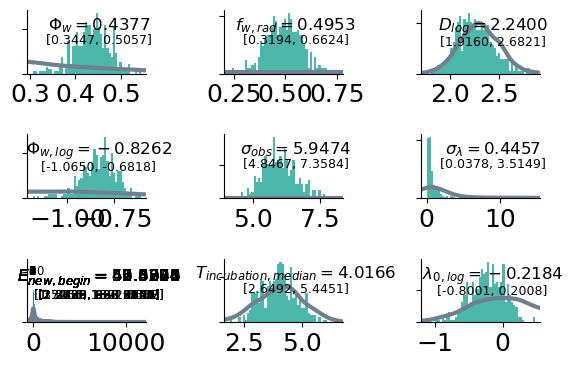

In [46]:
fig, axes = plt.subplots(3, 3, figsize=(6, 4))

for i, (key, math) in enumerate(
    # left column
    zip(["weekend_factor", 'weekend_factor_log', "new_E_begin"],
    ["\Phi_w", "\Phi_{w,log}", "E_{new,begin}"])
):
    cov19.plot.distribution(this_model, idata, key, ax=axes[i, 0], dist_math=math)

for i, (key, math) in enumerate(
    # mid column
    zip([
        'offset_modulation_rad',
        "sigma_obs", 
        'median_incubation',
    ],    [
        "f_{w,rad}",
        "\sigma_{obs}",
        "T_{incubation,median}",
    ])
):
    cov19.plot.distribution(this_model, idata, key, ax=axes[i, 1],dist_math=math,)

for i, (key,math) in enumerate(
    # right column
    zip([
        'delay_log', 
        'sigma_lambda_cp', 
        'lambda_0_log_', 
    ],[
        "D_{log}",
        "\sigma_\lambda",
        "\lambda_{0,log}"
    ])
):
    cov19.plot.distribution(this_model, idata, key, ax=axes[i, 2],dist_math=math,)

fig.tight_layout()

For the change points (>0)

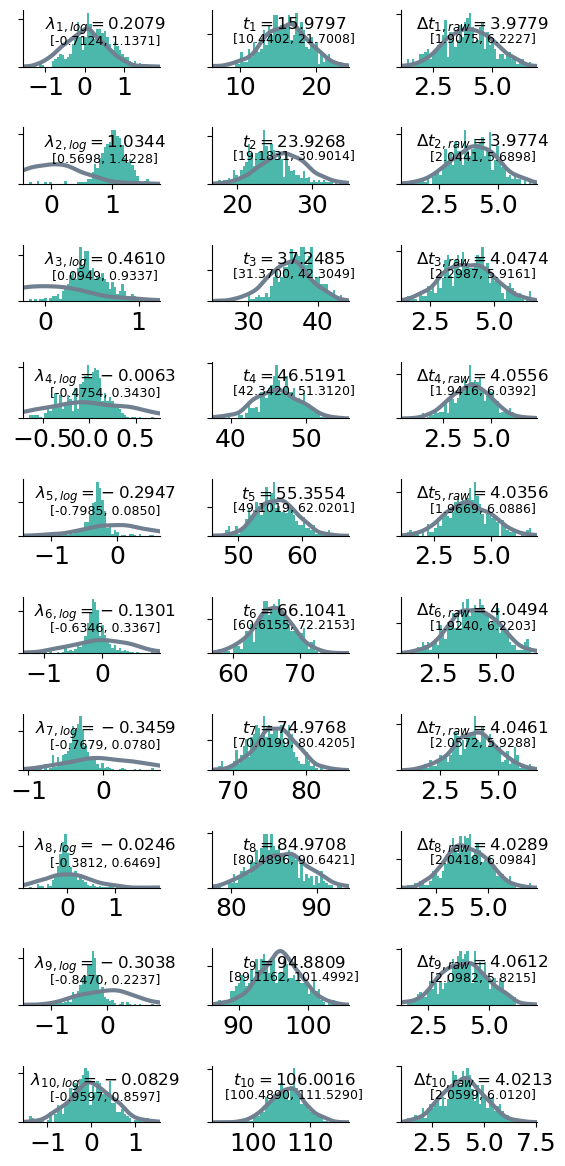

In [47]:
fig, axes = plt.subplots(len(change_points), 3, figsize=(6, len(change_points)+2))

for i in range(1,len(change_points)+1):
    cov19.plot.distribution(this_model, idata, f'lambda_{i}_log_', ax=axes[i-1, 0], dist_math=f"\lambda_{{{i},log}}")
    cov19.plot.distribution(this_model, idata, f'transient_day_{i}', ax=axes[i-1, 1], dist_math=f"t_{{{i}}}")
    cov19.plot.distribution(this_model, idata, f'transient_len_{i}_raw_', ax=axes[i-1, 2], dist_math=f"\Delta t_{{{i},raw}}")

fig.tight_layout()

### Timeseries

In [54]:
%autoreload
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../")
    import covid19_inference as cov19

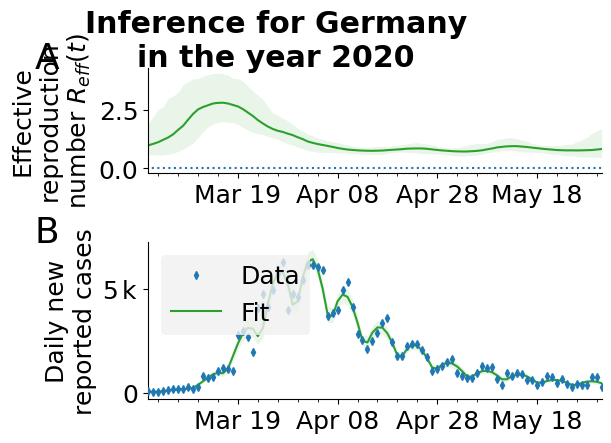

In [55]:
fig, axes = cov19.plot.timeseries_R_eff(this_model, 
                                        idata, 
                                        annotate_watermark=False, 
                                        save_to=f"../../figures/R_eff_{country}",
                                        start=datetime.datetime(2020,3,1)
                                       )

In [50]:
new_cases_after_SIR, x = cov19.plot.utils.get_array_from_idata_via_date(
        this_model, idata, "new_cases_after_SIR", bd, ed
    )
new_cases_after_delay, x = cov19.plot.utils.get_array_from_idata_via_date(
        this_model, idata, "delayed_cases", bd, ed
    )
y_past, x_past = cov19.plot.utils.get_array_from_idata_via_date(
        this_model, idata, "new_cases", bd, ed
    )

Text(0.5, 1.0, 'Germany in 2020')

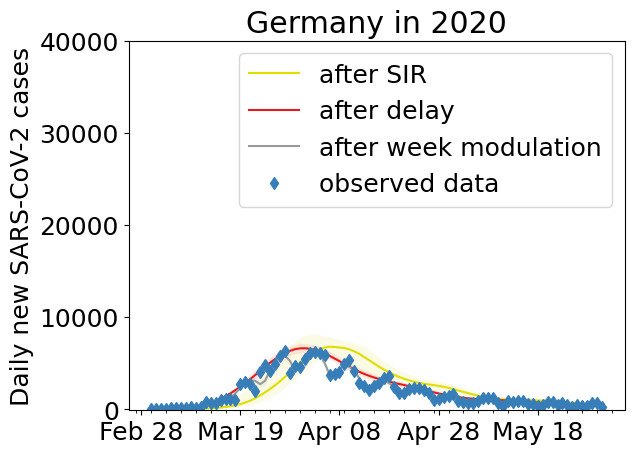

In [51]:
plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots()

cov19.plot.timeseries._timeseries(
            x=x,
            y=new_cases_after_SIR,
            ax=ax,
            what="model",
            label="after SIR",
            color='#dede00'
        )
cov19.plot.timeseries._timeseries(
            x=x,
            y=new_cases_after_delay,
            ax=ax,
            what="model",
            label="after delay",
            color='#e41a1c'
        )
cov19.plot.timeseries._timeseries(
            x=x_past,
            y=y_past,
            ax=ax,
            what="model",
            label="after week modulation",
            color='#999999',
            #linestyle=':'
        )

cov19.plot.timeseries._timeseries(
            x=x_past,
            y=new_cases_obs,
            ax=ax,
            what="data",
            label="observed data",
            color='#377eb8'
        )

ax.set_ylim(-100,4e4)
ax.legend()
ax.set_ylabel("Daily new SARS-CoV-2 cases")
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_minor_locator(plt.MaxNLocator(40))
ax.set_title(f"{country} in 2020")

In [17]:
y_I, x_I = cov19.plot.utils.get_array_from_idata_via_date(
        this_model, idata, "I_t", bd, ed
    )
y_S, x_S = cov19.plot.utils.get_array_from_idata_via_date(
        this_model, idata, "S_t", bd, ed
    )

plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots()

cov19.plot.timeseries._timeseries(
            x=x_I,
            y=y_I,
            ax=ax,
            what="model",
            label="I",
            color='#4daf4a'
        )
cov19.plot.timeseries._timeseries(
            x=x_S,
            y=y_S,
            ax=ax,
            what="model",
            label="S",
            color='#ff7f00'
        )
cov19.plot.timeseries._timeseries(
            x=x,
            y=this_model.N_population-y_I-y_S,
            ax=ax,
            what="model",
            label="R",
            color='#f781bf'
        )

#ax.set_ylim(-100,4e4)
ax.legend()
ax.set_ylabel("Number of people")
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_minor_locator(plt.MaxNLocator(40))
ax.set_title("Germany in 2020")

AssertionError: var should be in trace.varnames